# ORCO RIVER BASIN

13/10/2021

In this notebook results of different feature selections are compared for the Candoglia basin (of which we have around 18 years of data)

Input data is clipped from ERA5 metereological reanalysis quantile mapped and downscaled.

10 days average (for the previous year) of pecipitation, temperature and potential evapotranspiration are selected as input.


The settings are the following:

    A) 180 features are selected with PCA, the same numeriosity as setting C) ;

    B) 36 features are selectedwith PCA, the same numeriosity as setting D) ;
        
    C) metereological inputs spatial statistics are used as input: mean, the 5th, 25th, 75th and 95th quantiles are selected.
        
    D) metereological inputs are spatially averaged.




import sys
sys.path.append('/time_unit')

In [1]:
from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

In [2]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'

daily_input = pd.read_csv(path+'SAN_BENIGNO_ORCO_2002_2019.csv', index_col=0, parse_dates=True)

daily_input_TPE = spatial_avg_daily_input(daily_input)

daily_input_stat = spatial_stats_daily_input(daily_input)

In [5]:
daily_input

,Q,T10,T11,T21,T22,T23,T28,T29,T30,T31,...,E68,E76,E77,E78,E79,E80,E89,E90,E91,T
2001-01-01,NaN,272.636631,272.726163,273.034708,273.018517,272.815295,269.466917,269.092088,269.509232,271.592088,...,1.099277,0.832470,0.915544,0.821917,1.262092,1.287116,1.001550,1.063327,1.384084,268.155152
2001-01-02,NaN,273.703514,273.624776,274.200665,274.123734,273.834682,271.567929,270.960196,271.332635,273.220507,...,0.502051,0.330381,0.528166,0.520810,0.693244,0.631229,0.613465,0.663510,0.867598,270.177107
2001-01-03,NaN,273.662112,273.514825,273.928364,273.703004,273.445421,270.093453,269.834482,270.424504,272.485366,...,-0.185734,-0.191393,-0.107597,-0.241453,-0.218550,-0.171484,-0.124434,-0.150968,-0.137348,267.817979
2001-01-04,NaN,274.263070,274.174752,274.649502,274.633442,274.280124,271.745155,271.361658,272.009139,273.735508,...,0.023767,0.134277,0.271149,0.155526,0.159301,0.098424,0.301891,0.277729,0.339832,270.120416
2001-01-05,NaN,274.542130,274.411250,275.126302,274.946149,274.565653,272.435603,271.938562,272.538248,274.226722,...,0.437927,0.331204,0.522194,0.475785,0.630015,0.538916,0.566669,0.630663,0.818584,270.852392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,6.45,274.779155,274.728767,275.403446,275.302761,274.989875,273.878555,273.030360,273.273383,274.509414,...,0.369048,0.896172,0.920775,0.550625,0.766703,0.629438,0.980627,0.880541,1.048121,272.145776
2018-12-28,5.90,276.241003,276.277341,276.717540,276.697308,276.316895,275.111350,274.301690,274.592873,275.734779,...,0.049025,0.585482,0.644256,0.298274,0.279048,0.183700,0.680404,0.562820,0.610378,273.237923
2018-12-29,5.20,276.913277,276.855840,277.213167,277.127457,276.780174,275.441921,274.684419,275.011931,276.130990,...,-0.336622,-0.068893,-0.054837,-0.205009,-0.311072,-0.286201,-0.059699,-0.180909,-0.309121,272.962407
2018-12-30,4.55,278.392798,278.324183,278.591047,278.289345,278.234220,276.374897,275.663875,276.155345,277.356337,...,0.391843,0.812209,0.538389,-0.173796,0.526711,0.619517,0.826288,0.866297,1.056738,273.819281


In [6]:
import sys, importlib
importlib.reload(sys.modules['test'])


<module 'test' from 'C:\\Users\\mmazzolini\\OneDrive - Scientific Network South Tyrol\\Documents\\conda\\Runoff_prediction\\test.py'>

In [3]:
t_unit=5


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-2, 2, 10)
epsilon_range=np.logspace(-3, +0, 5)
#n_range = [17, 50, 200]
#do not enlarge t_range for now
t_range=[72]
t_length=t_range[0]
n_splits=5
test_size=365

# A) PCA+SVR

### TRAIN A PCA+SVR MODEL 

Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"



C=0.5994842503189409
eps=0.001
n=1080


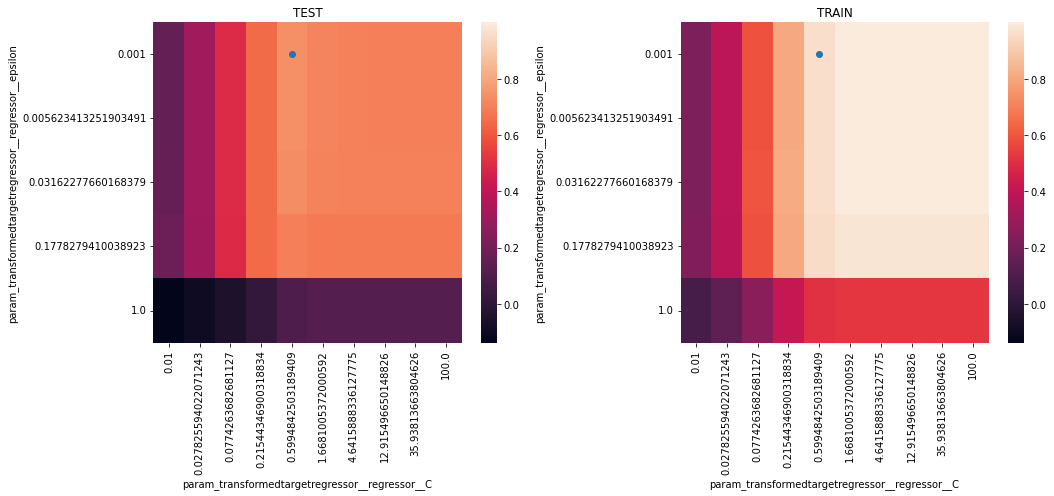

In [5]:
components_range = [5*3*72]

C,eps,n=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')
print(f'n={n}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [7]:
radius_for_ensemble = 1
predictions = nested_CV_PCA_SVR_predict(daily_input, C, eps, n, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

KeyError: '[199, 217, 229, 311] not in index'

predictions=pd.read_csv('tial.csv',date_parser=True)

In [ ]:
plot_prediction(predictions)

In [ ]:
r2_PCA180 = evaluate_prediction(predictions)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [ ]:
predictions_for_clim = classic_CV_PCA_SVR_predict(daily_input, C, eps, n, t_length,t_unit, n_splits)

In [ ]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split
plot_anomalies(a)

## B) PCA+SVR 

### TRAIN A PCA+SVR MODEL 

In [ ]:
components_range2=[72*3]
C2,eps2,n2=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range2, t_range,t_unit,n_splits,test_size)
print(f'C={C2}')
print(f'epsilon={eps2}')
print(f'n={n2}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [ ]:
radius_for_ensemble = 1
predictions2 = nested_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

predictions=pd.read_csv('tial.csv',date_parser=True)

In [ ]:
plot_prediction(predictions2)

In [ ]:
r2_PCA36 = evaluate_prediction(predictions2)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim2 = classic_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12, n_splits)
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


In [ ]:
climatologies2=climatologies

In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split
plot_anomalies(a2)

# C) SVR 
## WITH SPATIAL STATISTICS AS INPUT

In [ ]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C3={C3}')
print(f'eps3={eps3}') 

C3=0.5994842503189409
eps3=0.001

C3=0.5994842503189409
eps3=0.001

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [ ]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat, C3, eps3, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

In [ ]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

In [ ]:
r2_STATS= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [ ]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat, C3, eps3, t_length,t_unit, n_splits)

In [ ]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


climatologies3=climatologies

In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3)

# D) SVR 
## WITH SPATIAL AVERAGE AS INPUT

In [ ]:
C4, eps4 = SVR_nested_CV_gridsearch(daily_input_TPE, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C4={C4}')
print(f'eps4={eps4}')

C4=0.21544346900318834
eps4=0.01

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [ ]:
radius_for_ensemble = 1
predictions4 = nested_CV_SVR_predict(daily_input_stat, C4, eps4, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

In [ ]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions4)

In [ ]:
r2_TPE = evaluate_prediction(predictions4)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [ ]:
predictions_for_clim4 = classic_CV_SVR_predict(daily_input_stat, C4, eps4, t_length,t_unit, n_splits)

In [ ]:
climatologies4 =predictions_for_clim4.groupby(by=predictions_for_clim4.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies4['doty']=climatologies4.index


climatologies4=climatologies

In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies4,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies4,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a4=compute_anomalies(climatologies4, predictions4)
a4['split']=predictions4.split
plot_anomalies(a4)

# COMPARE RESULTS

In [ ]:
results = pd.concat([r2_PCA180,r2_PCA36,r2_STATS,r2_TPE],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

In [ ]:
r2_TPE_an = evaluate_prediction(a4)
r2_STATS_an= evaluate_prediction(a3)
r2_PCA36_an = evaluate_prediction(a2)
r2_PCA180_an = evaluate_prediction(a)

In [ ]:
results = pd.concat([r2_PCA180_an,r2_PCA36_an,r2_STATS_an,r2_TPE_an],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')